<a href="https://colab.research.google.com/github/nisar009/Kaggle_Notebooks/blob/master/fastai-v1-live-dl1/lesson_3_planets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi Label Classification - Identifying Satellite Images

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Setting up fastai, pytorch in Colab

In [0]:
%%capture
!curl https://course-v3.fast.ai/setup/colab | bash
# may need to restart the kernel here to avoid PIL Image issue

In [0]:
from fastai import *
from fastai.vision import *

## Getting the data from Kaggle

In [0]:
%%capture
! pip install kaggle-cli

In [0]:
%%capture
!mkdir -p data/planets && cd data/planets && kg download -u nisar009 -p p@55w0rd -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z

In [0]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" "https://storage.googleapis.com/kaggle-competitions-data/kaggle/6322/train_v2.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1542221090&Signature=G868N7TnE5NzyTk%2F%2BRIDvuQIZ26Ze5OEgm%2Be49eM4CJumPKOdvVsrSXIKYd9utbUt79LqtTrMMQOwQ32H7rGjLBGMIXsVCmCNHjcLYykNlj9HqcimxxlhzgMu99xIrbsokBOYtIGDX%2BNEgCccPvzfhmpMwGMycwKbiHgYrPLp1RJcy%2BrLeQaqtBfZEmkQxvRY%2FLH4V5x5d5mhTCnmQ9FvADZjbYx6mjvT5psiNWQbi4%2FO05rVuDF7MvDAvUtZqk4s6C6TKXz8mPt3agRzaDLaNODPXJjvE39Jj%2B4Wp6P9FJ%2F%2Fsixbwv0dZrhukibGn3bt0PBUVirpGcIntcTvrF%2BIw%3D%3D" -O "train_v2.csv.zip" -c

In [0]:
!mv train_v2.csv.zip planets/train_v2.csv.zip

In [0]:
%%capture
! conda install -y -c haasad eidl7zip

In [0]:
path = Config.data_path()/'planets'

In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

In [0]:
!cd planets && unzip train_v2.csv.zip

In [37]:
!cd planets && ls

__MACOSX  train-jpg  train-jpg.tar.7z  train_v2.csv  train_v2.csv.zip


### Multi Label Classification

Just checking the csv file that contains the labels.

In [38]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


No we have our data ready. We need to create a fastai DataBunch before feeding it to the model. We use the Data Block API of fastai to do this

In [0]:
# defining the transormations we will use for this data for data augmentation
# flip_vert - flip the image also vertically, default is only horizontal. satellite image vertical also make sense
# max_warp - warping of images respective to the perspective. not useful for satellite or medical images.
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=0.5, max_warp=0.)

In [0]:
np.random.seed(42)

src = (ImageFileList.from_folder(path)
      .label_from_csv('train_v2.csv', sep=' ', folder='train-jpg', suffix='.jpg')
      .random_split_by_pct(0.2))

In [0]:
data = (src.datasets()
        .transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

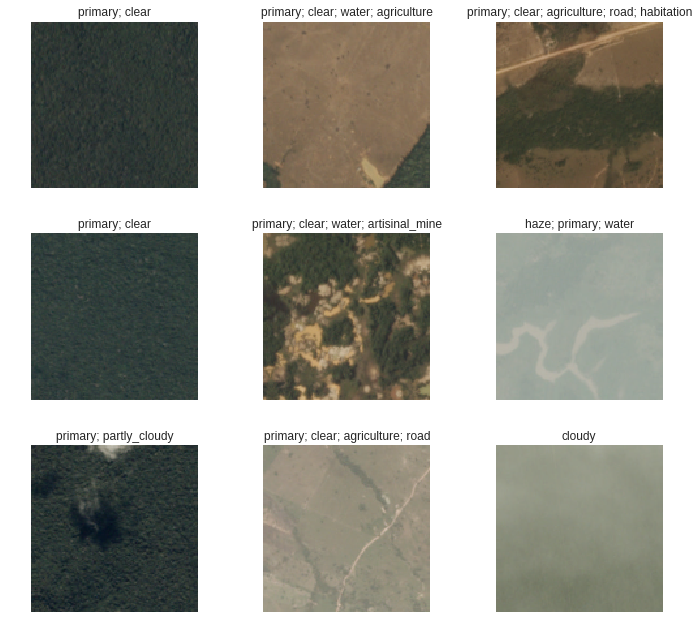

In [52]:
data.show_batch(rows=3, figsize=(10, 9))

### The Model

In [0]:
arch = models.resnet50

In [54]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

learn = create_cnn(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 70998709.80it/s]


We use the LR Finder to pick a good learning rate

In [55]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


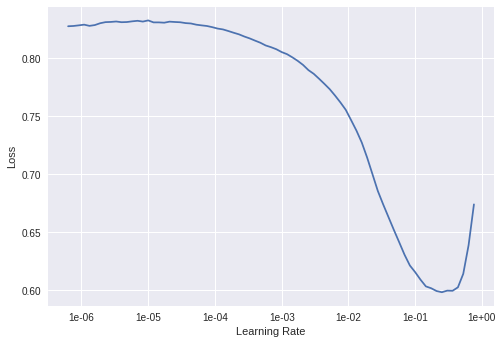

In [56]:
learn.recorder.plot()

In [0]:
lr = 1e-1/2

In [58]:
learn.fit_one_cycle(5, slice(lr))

Total time: 18:03
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.132543    0.133199    0.939425         0.886891  (03:39)
2      0.165019    0.156780    0.937092         0.872195  (03:36)
3      0.129844    0.117426    0.928358         0.895507  (03:35)
4      0.111518    0.131055    0.948509         0.917909  (03:35)
5      0.097700    0.108235    0.954365         0.922451  (03:36)



In [0]:
learn.save('stage-1-resnet50')

Now unfreeze and finetune the model

In [0]:
learn.unfreeze()

In [61]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


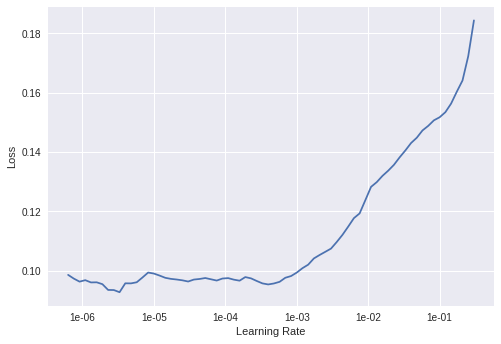

In [62]:
learn.recorder.plot()

In [63]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 22:34
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.107738    0.129847    0.949351         0.914661  (04:30)
2      0.109843    0.111140    0.953087         0.913140  (04:31)
3      0.101282    0.398318    0.956451         0.919437  (04:30)
4      0.096872    0.094146    0.955877         0.923803  (04:31)
5      0.091258    0.087618    0.956451         0.925346  (04:31)



In [0]:
learn.save('stage-2-resnet50')

Now we increase the size of the images and train some more. This is called **Progressize resizing**

In [65]:
data = (src.datasets(ImageMultiDataset)
       .transform(tfms, size=256)
       .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

/usr/local/lib/python3.6/dist-packages/fastai/vision/data.py:122: UserWarning: `ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.
  warnings.warn("`ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.")


torch.Size([3, 256, 256])

In [0]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


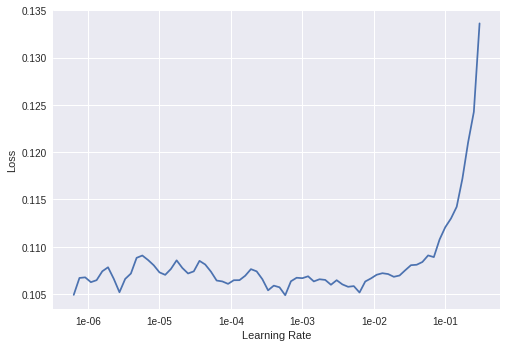

In [67]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2 / 2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.094239,0.114973,0.956989,0.922388
2,0.094794,0.092894,0.955972,0.924640
3,0.092054,0.087703,0.955375,0.925320
4,0.089136,0.090404,0.957229,0.927257
